# Step 3: Test, Train, Split, OneHotEncode, Model Function, GridSearch.

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import dates as mpl_dates
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import tree

In [2]:
df = pd.read_csv('data/cleaned_data')

In [3]:
df

,date,officer_age,officer_race,officer_gender,subject_age,subject_race,subject_gender,stop_resolution,weapon_type,initial_call_type,call_type,arrest,frisk
0,2015-09-13,23,White,M,Under 17,American Indian or Alaska Native,Male,Arrest,None,NaN,NaN,N,Y
1,2015-04-19,27,Not Specified,F,Under 17,Unknown,Male,Field Contact,None,NaN,NaN,N,Y
2,2015-04-20,27,White,M,Under 17,White,Male,Field Contact,None,NaN,NaN,N,N
3,2015-05-19,23,White,F,Under 17,Black or African American,Male,Field Contact,None,NaN,NaN,N,Y
4,2015-05-19,33,Nat Hawaiian/Oth Pac Islander,M,Under 17,Black or African American,Male,Field Contact,None,NaN,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43914,2021-07-14,31,White,M,56 and Above,White,Male,Field Contact,NaN,NaN,NaN,N,N
43915,2019-07-17,31,Black or African American,M,56 and Above,Black or African American,Male,Arrest,NaN,SHOPLIFT - THEFT,911,Y,N
43916,2019-11-08,50,White,M,56 and Above,Black or African American,Male,Offense Report,NaN,PURSE SNATCH - ROBBERY,ONVIEW,N,N
43917,2020-12-26,44,Hispanic or Latino,M,56 and Above,Black or African American,Male,Field Contact,NaN,SHOPLIFT - THEFT,911,N,N


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43919 entries, 0 to 43918
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               43919 non-null  object
 1   officer_age        43919 non-null  int64 
 2   officer_race       43919 non-null  object
 3   officer_gender     43919 non-null  object
 4   subject_age        43919 non-null  object
 5   subject_race       43919 non-null  object
 6   subject_gender     43919 non-null  object
 7   stop_resolution    43919 non-null  object
 8   weapon_type        32748 non-null  object
 9   initial_call_type  31596 non-null  object
 10  call_type          31596 non-null  object
 11  arrest             43919 non-null  object
 12  frisk              43919 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.4+ MB


### Splitting Data Set into X and Y

In [6]:
#isolate columns wanted to compare with frisk
frisk_columns = df.drop(columns=['frisk'], axis=1)

#Establish X and y
y = df['frisk']
X = frisk_columns 

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Remove 'object'-type features from X
cont_features = [col for col in X.columns if X[col].dtype in [np.float64, np.int64]]

# Remove "object"-type features from X_train and X_test
X_train_cont = X_train.loc[:, cont_features]
X_test_cont = X_test.loc[:, cont_features]

In [7]:
print(y.shape)
print(X.shape)

(43919,)
(43919, 12)


### Imputing, Scaling, Encoding 

In [9]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Impute missing values with median using SimpleImputer
impute = SimpleImputer(strategy='median', add_indicator=True)
X_train_imputed = impute.fit_transform(X_train_cont)
X_test_imputed = impute.transform(X_test_cont)

In [10]:
#normalize our data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Scale the train and test data
ss = StandardScaler()
X_train_imputed_scaled = ss.fit_transform(X_train_imputed)
X_test_imputed_scaled = ss.transform(X_test_imputed)

In [11]:
# Create X_cat which contains only the categorical variables
features_cat = [col for col in X.columns if X[col].dtype in [np.object]]
X_train_cat = X_train.loc[:, features_cat]
X_test_cat = X_test.loc[:, features_cat]

# Fill missing values with the string 'missing'
X_train_cat.fillna(value='missing', inplace=True)
X_test_cat.fillna(value='missing', inplace=True)

In [12]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncode categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform training and test sets
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

# Convert these columns into a DataFrame 
columns = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

In [13]:
#combining all the X_train categorial and continuous data
X_train_all = pd.concat([pd.DataFrame(X_train_imputed_scaled), cat_train_df], axis=1)
X_test_all = pd.concat([pd.DataFrame(X_test_imputed_scaled), cat_test_df], axis=1)

## Running our X_train, y_train through Machine Learning Function

In [14]:
#Create a function within many Machine Learning Models for train data

def models(X_train_all, y_train):
    
    #Using Logistic Regression Algorithm to the Training Set
    log = LogisticRegression(random_state = 0, max_iter = 50000)
    log.fit(X_train_all, y_train)
    
    
    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    knn.fit(X_train_all, y_train)
    

    #Using SVC method of svm class to use Support Vector Machine Algorithm
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(X_train_all, y_train)
    
    #Using SVC method of svm class to use Kernel SVM Algorithm
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(X_train_all, y_train)
    
    
    #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
    gauss = GaussianNB()
    gauss.fit(X_train_all, y_train)

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train_all, y_train)
    
    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_train_all, y_train)
    
    print('[0]Logistic Regression Training Accuracy:', log.score(X_train_all, y_train))
    print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train_all, y_train))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train_all, y_train))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train_all, y_train))
    print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train_all, y_train))
    print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train_all, y_train))
    print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train_all, y_train))
    
    return

In [ ]:
models(X_train_all, y_train)

## Running our X_test, y_test through Machine Learning Function

In [ ]:
#test data
def other_models(X_test_all, y_test):
    
    #Using Logistic Regression Algorithm to the Training Set
    log = LogisticRegression(random_state = 0, max_iter = 50000)
    log.fit(X_test_all, y_test)
    
    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    knn.fit(X_test_all, y_test)

    #Using SVC method of svm class to use Support Vector Machine Algorithm
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(X_test_all, y_test)
    
    #Using SVC method of svm class to use Kernel SVM Algorithm
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(X_test_all, y_test)
    
    #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
    gauss = GaussianNB()
    gauss.fit(X_test_all, y_test)

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree_test = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree_test.fit(X_test_all, y_test)
    
    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_test_all, y_test)
    
    print('[0]Logistic Regression Training Accuracy - X_test, y_test:', log.score(X_test_all, y_test))
    print('[1]K Nearest Neighbor Training Accuracy - X_test, y_test:', knn.score(X_test_all, y_test))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy - X_test, y_test:', svc_lin.score(X_test_all, y_test))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy - X_test, y_test:', svc_rbf.score(X_test_all, y_test))
    print('[4]Gaussian Naive Bayes Training Accuracy - X_test, y_test:', gauss.score(X_test_all, y_test))
    print('[5]Decision Tree Classifier Training Accuracy - X_test, y_test:', tree_test.score(X_test_all, y_test))
    print('[6]Random Forest Classifier Training Accuracy - X_test, y_test:', forest.score(X_test_all, y_test))
    
    return

In [ ]:
other_models(X_test_all, y_test)

Based on the modeling of train and test data, our best models are Decision Tree and Random Forest Classifier.

### Confusion Matrix and Classification Report for Decision Tree

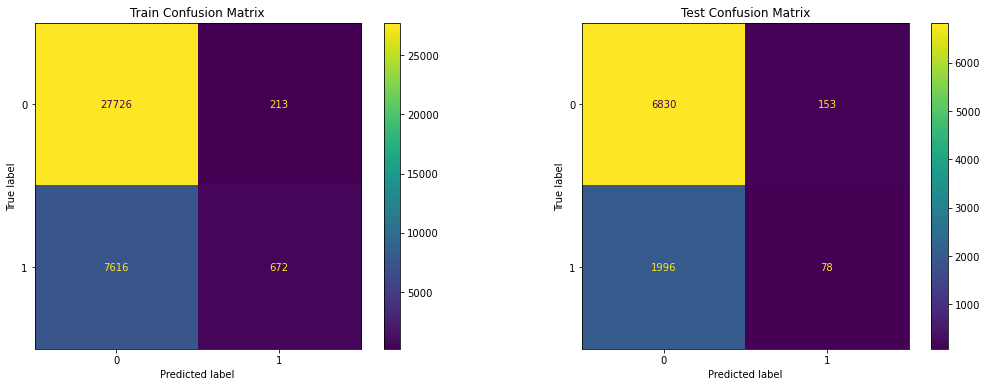

In [123]:
#start decision tree confusion matrix

#instantiation
tree_matrix = DecisionTreeClassifier()

#fitting
tree_matrix.fit(X_train_all, y_train)

#predictions
y_hat_train = tree_matrix.predict(X_train_all)
y_hat_test = tree_matrix.predict(X_test_all)

#plot decision tree confusion matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))

plot_confusion_matrix(tree_matrix, X_train_all, y_train, ax=ax0)
plot_confusion_matrix(tree_matrix, X_test_all, y_test, ax=ax1)

ax0.title.set_text('Train Confusion Matrix')
ax1.title.set_text('Test Confusion Matrix')

In [124]:
print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.78      0.99      0.88     27939
           1       0.76      0.08      0.15      8288

    accuracy                           0.78     36227
   macro avg       0.77      0.54      0.51     36227
weighted avg       0.78      0.78      0.71     36227

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      6983
           1       0.34      0.04      0.07      2074

    accuracy                           0.76      9057
   macro avg       0.56      0.51      0.47      9057
weighted avg       0.67      0.76      0.68      9057



In [107]:
#figure out what features are important by level
tree_matrix.feature_importances_
fi = sorted(list(zip(tree_matrix.feature_importances_, X_train.columns)))
fi = pd.DataFrame(fi, columns=['impt', 'name'], )
fi

,impt,name
0,0.009786,officer_race
1,0.020307,subject_gender
2,0.022424,subject_race
3,0.027235,officer_gender
4,0.469077,officer_age


<AxesSubplot:>

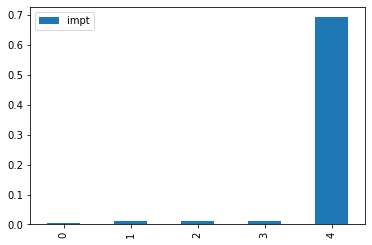

In [122]:
fi.plot(kind='bar')

Officer Age and Subject Race are the most important features that determine a frisk

### Confusion Matrix and Classification Report for Random Forest

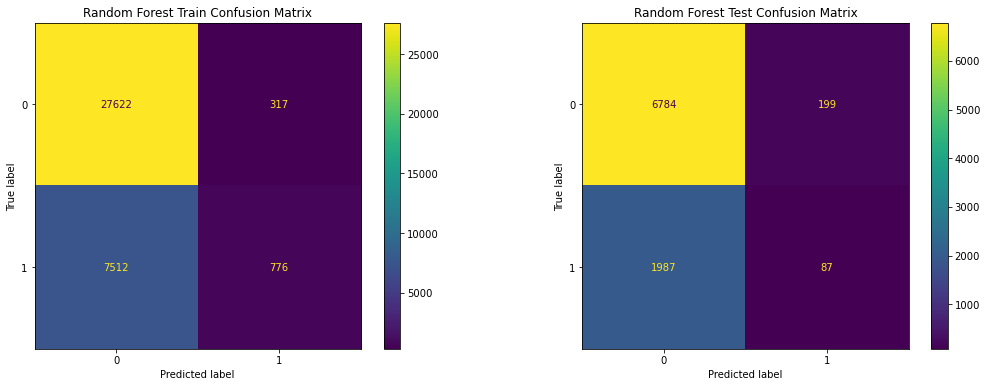

In [114]:
#start decision tree confusion matrix

#instantiation
random_forest = RandomForestClassifier()

#fitting
random_forest.fit(X_train_all, y_train)

#predictions
y_forest_hat_train = random_forest.predict(X_train_all)
y_forest_hat_test = random_forest.predict(X_test_all)

#plot decision tree confusion matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))

plot_confusion_matrix(random_forest, X_train_all, y_train, ax=ax0)
plot_confusion_matrix(random_forest, X_test_all, y_test, ax=ax1)

ax0.title.set_text('Random Forest Train Confusion Matrix')
ax1.title.set_text('Random Forest Test Confusion Matrix')

In [115]:
#run classification model for Random Forrest
print(classification_report(y_train, y_forest_hat_train))
print(classification_report(y_test, y_forest_hat_test))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     27939
           1       0.71      0.09      0.17      8288

    accuracy                           0.78     36227
   macro avg       0.75      0.54      0.52     36227
weighted avg       0.77      0.78      0.71     36227

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      6983
           1       0.30      0.04      0.07      2074

    accuracy                           0.76      9057
   macro avg       0.54      0.51      0.47      9057
weighted avg       0.67      0.76      0.68      9057



In [117]:
#figure out what features are important by level
tree_matrix.feature_importances_
fi = sorted(list(zip(random_forest.feature_importances_, X_train.columns)))
fi = pd.DataFrame(fi, columns=['impt', 'name'], )
fi

,impt,name
0,0.005233,officer_race
1,0.010542,officer_gender
2,0.010599,subject_gender
3,0.011274,subject_race
4,0.692129,officer_age


### GridSearch for Decision Tree

In [111]:
#gridsearch on decision tree

#copy X and y from above
y_train_post = y_train
X_train_post = X_train_all

#scale
std_slc = StandardScaler()

#using PCA object to make dataset more condense? Found on: https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python
pca = decomposition.PCA()

#set decision tree again
dec_tree = tree.DecisionTreeClassifier()

#Create a pipeline of three steps
## Standardize data, transform with PCA, then train decision tree classifier on data
pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('dec_tree', dec_tree)])

n_components = list(range(1,X.shape[1]+1,1))

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

#create parameter space
parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)
    
#establishing classifier
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train_post, y_train_post)

#print statements

print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])


Best Criterion: gini
Best max_depth: 2
Best Number Of Components: 1

DecisionTreeClassifier(max_depth=2)


In [73]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train_all, y_train)

gs_tree.best_params_

C:\Users\letru\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\letru\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\letru\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 903, in fit
    super().fit(
  File "C:\Users\letru\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\letru\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The s

C:\Users\letru\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\letru\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\letru\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 903, in fit
    super().fit(
  File "C:\Users\letru\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\letru\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The s

C:\Users\letru\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.77119103 0.77119103 0.77119103        nan 0.77119103
 0.77119103 0.77119103        nan 0.7710827  0.77110979 0.77100147
        nan 0.76883501 0.76894334 0.76921414        nan 0.77119103
 0.77119103 0.77119103        nan 0.77119103 0.77119103 0.77119103
        nan 0.77102855 0.77102855 0.77102855        nan 0.7688621
 0.76880794 0.76918707]
  warnings.warn(


{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}

#### Running the function with GridSearch Recommendations

In [125]:
#test data
def edited_test_models(X_test_all, y_test):

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree_grid = DecisionTreeClassifier(criterion = 'gini', random_state = 0, max_depth=1)
    tree_grid.fit(X_test_all, y_test)
    
    print('Decision Tree Classifier Training Accuracy - Test:', tree_grid.score(X_test_all, y_test))
    
    return

In [126]:
edited_test_models(X_test_all, y_test)

Decision Tree Classifier Training Accuracy - Test: 0.7710058518273158


In [127]:
def edited_train_models(X_train_all, y_train):

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree_train_grid = DecisionTreeClassifier(criterion = 'gini', random_state = 0, max_depth=1)
    tree_train_grid.fit(X_train_all, y_train)
    
    print('Decision Tree Classifier Training Accuracy - Train:', tree_train_grid.score(X_test_all, y_test))
    
    return

In [128]:
edited_train_models(X_train_all, y_train)

Decision Tree Classifier Training Accuracy - Train: 0.7710058518273158


## SMOTE

In [129]:
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [130]:
y_train.value_counts()

0    27939
1     8288
Name: frisk, dtype: int64

In [131]:
oversample = SMOTE()

X_train_smote, y_train_smote = oversample.fit_resample(X_train_all, y_train)
print(X_train_smote.shape, y_train_smote.shape)

(55878, 22) (55878,)


In [132]:
y_train_smote.value_counts()

1    27939
0    27939
Name: frisk, dtype: int64

In [67]:
model = DecisionTreeClassifier()
model.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier()

In [133]:
# note predictions are on the non-smoted data!!!

train_preds = model.predict(X_train_all)
test_preds = model.predict(X_test_all)

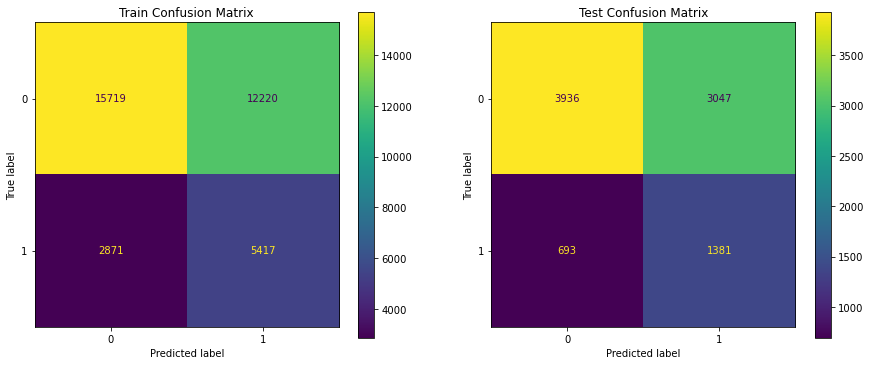

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plot_confusion_matrix(model, X_train_all, y_train, ax=ax[0])
plot_confusion_matrix(model, X_test_all, y_test, ax=ax[1])
ax[0].grid(False)
ax[1].grid(False)
ax[0].title.set_text('Train Confusion Matrix')
ax[1].title.set_text('Test Confusion Matrix')

In [135]:
train_smote = model.predict(X_train_smote)
print(classification_report(y_train_smote, train_smote))

              precision    recall  f1-score   support

           0       0.66      0.56      0.61     27939
           1       0.62      0.71      0.66     27939

    accuracy                           0.63     55878
   macro avg       0.64      0.63      0.63     55878
weighted avg       0.64      0.63      0.63     55878

